<a href="https://colab.research.google.com/github/TehilaC/Expert-Ranking-Algorithm-in-Online-Communities/blob/main/Analyze_Reddit_20240819.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**כניסה לגוגל**

In [ ]:
#from google.colab import auth
#auth.authenticate_user()

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.stats import zscore

import matplotlib.pyplot as plt
from networkx import Graph

from urllib.request import urlopen
from bs4 import BeautifulSoup

import codecs

*   Get posts & comments data from BigQuery
*   Save merge df




In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

# Authenticate to BigQuery
credentials = service_account.Credentials.from_service_account_file(
    '/content/savvy-night-308317-be1fc47939da.json'
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Define queries to get the necessary data
posts_query = """
select id, title, selftext, ups, downs, subreddit, author, author_fullname, DATETIME(TIMESTAMP_SECONDS(cast(created_utc as int64))) AS datetime_utc, num_comments, num_crossposts, num_reports, score
from `savvy-night-308317.reddit.Posts_clean`
"""

comments_query = """
select id, link_id , body , parent_id, ups, downs, subreddit, author, author_fullname, DATETIME(TIMESTAMP_SECONDS(cast(created_utc as int64))) AS datetime_utc,score
from `savvy-night-308317.reddit.Comments_clean`
"""

# Execute queries
posts_df_source = client.query(posts_query).to_dataframe()
comments_df_source = client.query(comments_query).to_dataframe()

# Merging comments with their respective posts
# Extract the post ID from the link_id in comments
comments_df_source['post_id'] = comments_df_source['link_id'].str.extract(r't3_(.*)')

# Initialize a column for post_id in comments_df to track the original post for subcomments
comments_df_source['original_comment_id'] = comments_df_source['parent_id'].str.extract(r't1_(.*)')

In [ ]:
year = 2013
subrredit = 'Python'
#subrredit = 'learnpython'

In [ ]:
posts_df = posts_df_source[posts_df_source['subreddit'].apply(lambda x: x == subrredit )]
comments_df = comments_df_source[ comments_df_source['subreddit'].apply(lambda x: x == subrredit )]
posts_df = posts_df.loc[(posts_df['datetime_utc'].dt.year >= 2015 )& (posts_df['datetime_utc'].dt.year<= 2023 )]

comments_df.loc[:, 'author_fullname'] = comments_df['author_fullname'].fillna(comments_df['author'])
posts_df.loc[:, 'author_fullname'] = posts_df['author_fullname'].fillna(posts_df['author'])

In [ ]:
#remove [delete] users
comments_df = comments_df[comments_df['author_fullname'] != '[deleted]']
posts_df = posts_df[posts_df['author_fullname'] != '[deleted]']

Merge posts and commens

In [ ]:
# Merge comments with posts
merged_df = comments_df.merge(posts_df, left_on='post_id', right_on='id', suffixes=('_comment', '_post'))

In [ ]:
edge_list = merged_df[[ 'author_post', 'author_fullname_post', 'author_comment', 'author_fullname_comment'
                       , 'score_comment' , 'score_post' ,'id_post', 'id_comment']]

Cleaning

In [ ]:
posts_df = posts_df.drop_duplicates()
comments_df = comments_df.drop_duplicates()
edge_list = edge_list.dropna()

In [ ]:
# delete all selfeloop edges
edge_list = edge_list[edge_list['author_fullname_post'] != edge_list['author_fullname_comment']]

Create **users** df:


*   Only active users
*   no duplicates
*   Additional data:
    *  Posts : num of posts, sum of all scores
    *  Comments : num of comments, sum of all comments, unique count of askers

In [ ]:
all_users = pd.concat([posts_df["author_fullname"], comments_df["author_fullname"]]).reset_index(name='author_fullname')
#all_users = pd.concat([edge_list['author_fullname_post'], edge_list['author_fullname_comment']]).reset_index(name='author_fullname')
print(len(all_users) )
all_users.drop_duplicates()
print(len(all_users) )

# add scores - calculate karama
post_score_sum = edge_list.groupby('author_fullname_post').agg({
    'score_post': 'sum',
    'id_post': 'nunique'
}).rename(columns={
    'id_post': 'count_unique_posts',
    'score_post': 'post_score_sum'
}).reset_index()
all_users = all_users.merge(post_score_sum, how='left', left_on='author_fullname', right_on='author_fullname_post')

comments_score_sum = edge_list.groupby('author_fullname_comment').agg({
    'score_comment': 'sum',
    'id_comment': 'nunique',
    'author_fullname_post': 'nunique'
}).rename(columns={
    'score_comment': 'comments_score_sum',
    'id_comment': 'count_unique_comment',
    'author_fullname_post': 'count_unique_posts_asker'
}).reset_index()

all_users = all_users.merge(comments_score_sum, how='left', left_on='author_fullname', right_on='author_fullname_comment')
all_users.fillna(0, inplace=True)

# calclulate karama for user
all_users['karama'] = all_users['post_score_sum'] + all_users['comments_score_sum']

1235154
1235154


In [ ]:
all_users.reset_index(drop=True, inplace=True)
all_users = all_users.drop_duplicates(subset = 'author_fullname')
print(len(all_users) )


161165


In [ ]:
edges_list_grouped = edge_list.groupby(['author_fullname_comment', 'author_fullname_post'])['score_comment'].sum().reset_index(name='score_comment')

# set up negative values
def non_negative_edges_total():
  min_score = edges_list_grouped['score_comment'].min()
  print("min_score: ", min_score)
  if min_score < 0:
      abs_min_score = abs(min_score) + 1
      print("abs_min_score: ", abs_min_score)
      edges_list_grouped['score_comment'] = edges_list_grouped['score_comment'] + abs_min_score

#non_negative_edges_total()

edges_l = edges_list_grouped[['author_fullname_post', 'author_fullname_comment', 'score_comment']].values.tolist()


In [ ]:
edges_list_grouped_corr = edges_list_grouped.groupby(['author_fullname_comment'])['score_comment'].sum().reset_index(name='score_comment_corr')
all_users = all_users.merge(edges_list_grouped_corr, how='left', left_on='author_fullname', right_on='author_fullname_comment')
all_users.fillna(0, inplace=True)

Create Graph

In [ ]:
print( "users: " , len(all_users))
print( "posts: " , len(posts_df))
print( "comments: " , len(comments_df))
print( "edge_list: " , len(edge_list) )
print( "merge: " , len(merged_df) )

users:  161165
posts:  140288
comments:  1039729
edge_list:  617577
merge:  729203


In [ ]:
G=nx.DiGraph()

In [ ]:
nodes_users = all_users['author_fullname']
G.add_nodes_from(nodes_users)

G.add_weighted_edges_from(edges_l)

# graph properties:
print("Is Directed:", G.is_directed())
print("Num Edges of graph: ")
print(G.number_of_edges())
print("Num Nodes of graph: ")
print(G.number_of_nodes())
print("in degree")
print(len(G.in_degree))
print("out degree")
print(len(G.out_degree()))

Is Directed: True
Num Edges of graph: 
434758
Num Nodes of graph: 
161165
in degree
161165
out degree
161165


In [ ]:
# remobve inner edges

print(G.number_of_edges())
#G.remove_edges_from(nx.selfloop_edges(G))
print(G.number_of_edges())

434758
434758


In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

In [ ]:
def non_negative_weights(graph):
  # Find the minimum weight in the graph
  min_weight = min(w for u, v, w in graph.edges(data='weight'))
  print(min_weight)
  # Check if there are negative weights
  # Adjust weights if there are negative values
  if min_weight < 0:
      adjustment = abs(min_weight) + 1
      for u, v in graph.edges():
          graph[u][v]['weight'] += adjustment

#non_negative_weights(G)

In [ ]:
# Store the original weights for correlation analysis
original_weights = {}
for u, v, weight in G.edges(data='weight'):
        if v not in original_weights:
            original_weights[v] = 0
        original_weights[v] += weight

# Extract PageRank scores and corresponding original weights
nodes = list(G.nodes)

original_weights_scores = [original_weights.get(0 , node ) for node in nodes]
#original_weights
all_users['weight'] = all_users['author_fullname'].map(original_weights).astype(float)

In [ ]:
import networkx as nx
a = 0.85

pr=nx.pagerank(G, a , weight='weight', max_iter = 1000000 , tol=1e-6) #

In [ ]:
all_users['pr'] = all_users['author_fullname'].map(pr).astype(float)
all_users['PageRank_Rank'] = all_users['pr'].rank(ascending=False)
all_users['Karama_Rank'] = all_users['comments_score_sum'].rank(ascending=False)

In [ ]:
hubs, authorities = nx.hits(G, max_iter = 1000000 , normalized = True)

all_users['hubs'] = all_users['author_fullname'].map(hubs) .astype(float)
all_users['authorities'] = all_users['author_fullname'].map(authorities) .astype(float)
all_users['Hubs_Rank'] = all_users['hubs'].rank(ascending=False)
all_users['Authorities_Rank'] = all_users['authorities'].rank(ascending=False)

In [ ]:
all_users['weight'] = all_users['weight'].fillna(0)

In [ ]:
from scipy.stats import spearmanr, kendalltau

# Calculating Spearman and Kendall correlations
spearman_pagerank_rho, p = spearmanr(all_users['PageRank_Rank'], all_users['Karama_Rank'])
kendall_pagerank_tau, _ = kendalltau(all_users['PageRank_Rank'], all_users['Karama_Rank'])

spearman_hubs_rho, p = spearmanr(all_users['Hubs_Rank'], all_users['Karama_Rank'])
kendall_hubs_tau, _ = kendalltau(all_users['Hubs_Rank'], all_users['Karama_Rank'])

spearman_authorities_rho, p = spearmanr(all_users['Authorities_Rank'], all_users['Karama_Rank'])
kendall_authorities_tau, _ = kendalltau(all_users['Authorities_Rank'], all_users['Karama_Rank'])

In [ ]:
all_users['Karama_Rank_Weight'] = all_users['weight'].rank(ascending=False)
all_users['Karama_Rank_score'] = all_users['comments_score_sum'].rank(ascending=False)

In [ ]:

#print( spearmanr((all_users['pr']), (all_users['score_comment_corr'])) )
#print( kendalltau(( all_users['pr']), (all_users['score_comment_corr']) ))
print( spearmanr((all_users['pr']), (all_users['comments_score_sum'])) )
print( kendalltau(( all_users['pr']), (all_users['comments_score_sum']) ))

print( spearmanr((all_users['Karama_Rank_score']), (all_users['PageRank_Rank'])) )
print( kendalltau(( all_users['Karama_Rank_score']), (all_users['PageRank_Rank']) ))

print( spearmanr(all_users['Karama_Rank_score'], all_users['Karama_Rank_Weight']) )
print( kendalltau(all_users['Karama_Rank_score'], all_users['Karama_Rank_Weight']) )

SignificanceResult(statistic=0.8067749674954641, pvalue=0.0)
SignificanceResult(statistic=0.6572108854741032, pvalue=0.0)
SignificanceResult(statistic=0.8067749674954641, pvalue=0.0)
SignificanceResult(statistic=0.6572108854741032, pvalue=0.0)
SignificanceResult(statistic=1.0, pvalue=0.0)
SignificanceResult(statistic=1.0, pvalue=0.0)


In [ ]:
all_users['calc_score'] = all_users['weight'] / ( all_users['count_unique_comment'] / all_users['count_unique_posts_asker']  )
all_users['calc_score'] = all_users['calc_score'].fillna(0)

In [ ]:
all_users['Rank_score_sum'] = all_users['comments_score_sum'].rank(ascending=False)

In [ ]:
print( spearmanr((all_users['comments_score_sum']), (all_users['calc_score'])) )
print( kendalltau(( all_users['comments_score_sum']), (all_users['calc_score']) ))

print( spearmanr((all_users['pr']), (all_users['calc_score'])) )
print( kendalltau(( all_users['pr']), (all_users['calc_score']) ))

SignificanceResult(statistic=0.9885171621568797, pvalue=0.0)
SignificanceResult(statistic=0.9501807629389065, pvalue=0.0)
SignificanceResult(statistic=0.8009746804039464, pvalue=0.0)
SignificanceResult(statistic=0.6512160222830037, pvalue=0.0)


In [ ]:
all_users['Rank_calc_score'] = all_users['calc_score'].rank(ascending=False)

In [ ]:
all_users['z_score'] = zscore( all_users['comments_score_sum'] )

In [ ]:
# Formatting results into a table
results = {
    'year' : [year],
    'year' : [year],
    'num nodes':[num_nodes],
    'num edges' : [num_edges],
    'a': [a],
    'ExpertRank_Spearman’s rho': [spearman_pagerank_rho],
    'ExpertRank_Kendall’s Tau': [kendall_pagerank_tau],
    'HITS Hubs_Spearman’s rho': [spearman_hubs_rho],
    'HITS Hubs_Kendall’s Tau': [kendall_hubs_tau],
    'HITS Auth_Spearman’s rho': [spearman_authorities_rho],
    'HITS Auth_Kendall’s Tau': [kendall_authorities_tau]
}

# Creating DataFrame
df_results = pd.DataFrame(results)

# Displaying the formatted DataFrame
df_results.head()

,year,num nodes,num edges,a,ExpertRank_Spearman’s rho,ExpertRank_Kendall’s Tau,HITS Hubs_Spearman’s rho,HITS Hubs_Kendall’s Tau,HITS Auth_Spearman’s rho,HITS Auth_Kendall’s Tau
0,2013,161165,434758,0.85,0.806775,0.657211,-0.496993,-0.397632,0.731089,0.563228


In [ ]:
all_users['Post_Rank'] = all_users['count_unique_posts'].rank(ascending=False)
print( spearmanr(all_users['Hubs_Rank'], all_users['Post_Rank']) )
print( kendalltau(all_users['Hubs_Rank'], all_users['Post_Rank']) )

SignificanceResult(statistic=0.9216456530634035, pvalue=0.0)
SignificanceResult(statistic=0.8415443125482248, pvalue=0.0)


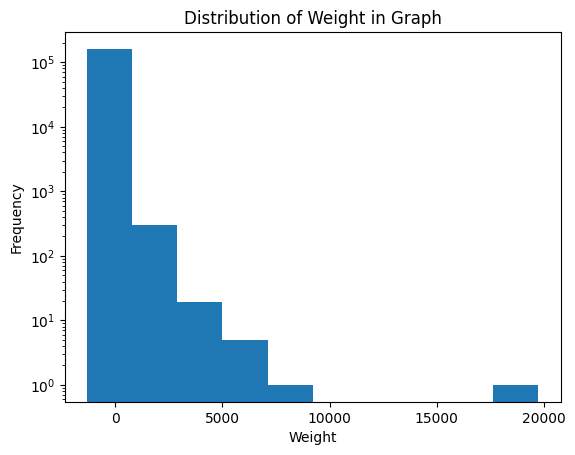

In [ ]:
import matplotlib.pyplot as plt

# Extract weights from the graph
weights = all_users['comments_score_sum']
#all_users['weight']

# Plot the distribution of weights
plt.hist(weights , bins = 10, log = True )
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Weight in Graph')
plt.show()

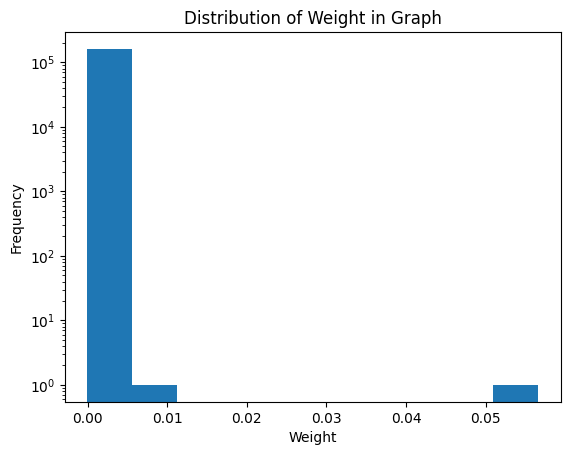

In [ ]:
import matplotlib.pyplot as plt

# Extract weights from the graph
weights = all_users['pr']
#all_users['weight']

# Plot the distribution of weights
plt.hist(weights , bins = 10, log = True )
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Weight in Graph')
plt.show()

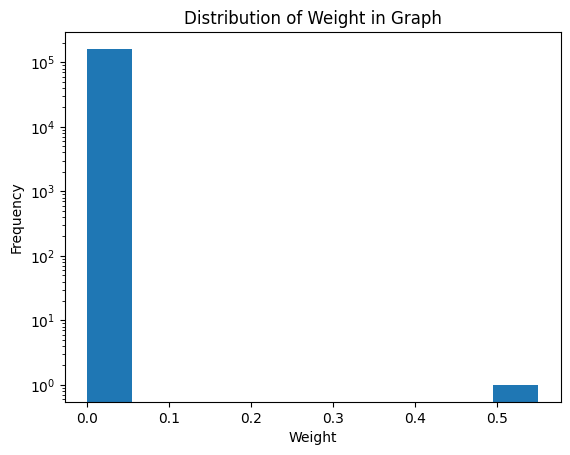

In [ ]:
import matplotlib.pyplot as plt

# Extract weights from the graph
weights = all_users['authorities']
#all_users['weight']

# Plot the distribution of weights
plt.hist(weights , bins = 10, log = True )
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Weight in Graph')
plt.show()

In [ ]:
all_users.to_csv('users.csv')